**Chương 16 - Xử lý ngôn ngữ tự nhiên với RNN và Tập trung (Attention)**

_Jupyter Notebook này chứa tất cả mã lập trình mẫu và lời giải cho các bài tập trong chương 16._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/mlbvn/handson-ml2-vn/blob/main/16_nlp_with_rnns_and_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/mlbvn/handson-ml2-vn/blob/main/16_nlp_with_rnns_and_attention.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Cài đặt

Đầu tiên hãy nhập một vài mô-đun thông dụng, đảm bảo rằng Matplotlib sẽ vẽ đồ thị ngay trong notebook, và chuẩn bị một hàm để lưu đồ thị. Ta cũng kiểm tra xem Python phiên bản từ 3.5 trở lên đã được cài đặt hay chưa (mặc dù Python 2.x vẫn có thể hoạt động, phiên bản này đã không còn sử dụng nên chúng tôi rất khuyến khích việc sử dụng Python 3), cũng như Scikit-Learn ≥ 0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if IS_COLAB:
    %pip install -q -U tensorflow-addons
    %pip install -q -U transformers

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "nlp"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


# Char-RNN

## Chia một chuỗi thành những batch chứa các cửa sổ xáo trộn

Ví dụ, hãy chia chuỗi từ 0 đến 14 thành các cửa sổ có độ dài 5, mỗi lần dịch chuyển 2 đơn vị (ví dụ `[0, 1, 2, 3, 4]`, `[2, 3, 4, 5, 6]`, v.v.), rồi xáo trộn chúng và chia chúng thành các đầu vào (4 bước đầu tiên) và các mục tiêu (4 bước cuối) (ví dụ `[2, 3, 4, 5, 6]` sẽ được chia thành `[[2, 3, 4, 5], [3, 4, 5, 6]]`), tiếp đó tạo các batch gồm 3 cặp đầu vào/mục tiêu như thế:

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

n_steps = 5
dataset = tf.data.Dataset.from_tensor_slices(tf.range(15))
dataset = dataset.window(n_steps, shift=2, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(n_steps))
dataset = dataset.shuffle(10).map(lambda window: (window[:-1], window[1:]))
dataset = dataset.batch(3).prefetch(1)
for index, (X_batch, Y_batch) in enumerate(dataset):
    print("_" * 20, "Batch", index, "\nX_batch")
    print(X_batch.numpy())
    print("=" * 5, "\nY_batch")
    print(Y_batch.numpy())

____________________ Batch 0 
X_batch
[[6 7 8 9]
 [2 3 4 5]
 [4 5 6 7]]
===== 
Y_batch
[[ 7  8  9 10]
 [ 3  4  5  6]
 [ 5  6  7  8]]
____________________ Batch 1 
X_batch
[[ 0  1  2  3]
 [ 8  9 10 11]
 [10 11 12 13]]
===== 
Y_batch
[[ 1  2  3  4]
 [ 9 10 11 12]
 [11 12 13 14]]


## Tải Dữ liệu và Chuẩn bị Bộ dữ liệu

In [3]:
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

1122304/1115394 [==============================] - 0s 0us/step


In [4]:
print(shakespeare_text[:148])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?



In [5]:
"".join(sorted(set(shakespeare_text.lower())))

"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

In [6]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

In [7]:
tokenizer.texts_to_sequences(["First"])

[[20, 6, 9, 8, 3]]

In [8]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

['f i r s t']

In [9]:
max_id = len(tokenizer.word_index) # number of distinct characters
dataset_size = tokenizer.document_count # total number of characters

In [10]:
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

**Lưu ý**: ở các phiên bản trước của mã này, ta đã sử dụng `dataset.repeat()`, bây giờ để tạo bộ dử liệu "vô tận", và sau đó trong notebook ta thiết lập đối số `steps_per_epoch` khi gọi phương thức `model.fit()`. Điều này cần để giải quyết một số lỗi của TensorFlow. Tuy nhiên, vì các lỗi này đã được sửa, ta có thể đơn giản hóa mã: không cần `dataset.repeat()` hay `steps_per_epoch` nữa.

In [11]:
n_steps = 100
window_length = n_steps + 1 # target = input shifted 1 character ahead
dataset = dataset.window(window_length, shift=1, drop_remainder=True)

In [12]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

In [13]:
np.random.seed(42)
tf.random.set_seed(42)

In [14]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

In [15]:
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))

In [16]:
dataset = dataset.prefetch(1)

In [17]:
for X_batch, Y_batch in dataset.take(1):
    print(X_batch.shape, Y_batch.shape)

(32, 100, 39) (32, 100)


## Tạo và Huấn luyện Mô hình

**Cảnh báo**: đoạn mã sau có thể cần tới 24 giờ để chạy, tùy thuộc vào phần cứng của bạn. Nếu bạn sử dụng GPU, thời gian chạy chỉ 1 hoặc 2 giờ, hoặc có thể ít hơn.

**Lưu ý**: lớp `GRU` chỉ sử dụng GPU (nếu bạn có) khi sử dụng các giá trị mặc định cho các đối số sau: `activation`, `recurrent_activation`, `recurrent_dropout`, `unroll`, `use_bias` và `reset_after`. Vì vậy, chúng tôi loại `recurrent_dropout=0.2` ra khỏi quá trình chạy mã (so với sách).

In [18]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id],
                     #dropout=0.2, recurrent_dropout=0.2),
                     dropout=0.2),
    keras.layers.GRU(128, return_sequences=True,
                     #dropout=0.2, recurrent_dropout=0.2),
                     dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, epochs=10)

Epoch 1/10
31368/31368 [==============================] - 7150s 228ms/step - loss: 1.4671
Epoch 2/10
31368/31368 [==============================] - 7094s 226ms/step - loss: 1.3614
Epoch 3/10
31368/31368 [==============================] - 7063s 225ms/step - loss: 1.3404
Epoch 4/10
31368/31368 [==============================] - 7039s 224ms/step - loss: 1.3311
Epoch 5/10
31368/31368 [==============================] - 7056s 225ms/step - loss: 1.3256
Epoch 6/10
31368/31368 [==============================] - 7049s 225ms/step - loss: 1.3209
Epoch 7/10
31368/31368 [==============================] - 7068s 225ms/step - loss: 1.3166
Epoch 8/10
31368/31368 [==============================] - 7030s 224ms/step - loss: 1.3138
Epoch 9/10
31368/31368 [==============================] - 7061s 225ms/step - loss: 1.3120
Epoch 10/10
31368/31368 [==============================] - 7177s 229ms/step - loss: 1.3105


## Sử dụng Mô hình để Sinh Văn bản

In [19]:
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, max_id)

**Cảnh báo**: phương thức `predict_classes()`không còn dùng nữa. Thay vào đó, ta phải sử dụng `np.argmax(model(X_new), axis=-1)`.

In [20]:
X_new = preprocess(["How are yo"])
#Y_pred = model.predict_classes(X_new)
Y_pred = np.argmax(model(X_new), axis=-1)
tokenizer.sequences_to_texts(Y_pred + 1)[0][-1] # 1st sentence, last char

'u'

In [21]:
tf.random.set_seed(42)

tf.random.categorical([[np.log(0.5), np.log(0.4), np.log(0.1)]], num_samples=40).numpy()

array([[0, 1, 0, 2, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 2, 1, 0, 2, 1,
        0, 1, 2, 1, 1, 1, 2, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 2]])

In [22]:
def next_char(text, temperature=1):
    X_new = preprocess([text])
    y_proba = model(X_new)[0, -1:, :]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

In [23]:
tf.random.set_seed(42)

next_char("How are yo", temperature=1)

'u'

In [24]:
def complete_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [25]:
tf.random.set_seed(42)

print(complete_text("t", temperature=0.2))

the belly the charges of the other words
and belly 


In [26]:
print(complete_text("t", temperature=1))

thing! they know't.

biondello:
for you are the own


In [27]:
print(complete_text("t", temperature=2))

th no cyty
use ffor was firive this toighingaber; b


## RNN Trạng thái

In [28]:
tf.random.set_seed(42)

In [29]:
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_length))
dataset = dataset.batch(1)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

In [30]:
batch_size = 32
encoded_parts = np.array_split(encoded[:train_size], batch_size)
datasets = []
for encoded_part in encoded_parts:
    dataset = tf.data.Dataset.from_tensor_slices(encoded_part)
    dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_length))
    datasets.append(dataset)
dataset = tf.data.Dataset.zip(tuple(datasets)).map(lambda *windows: tf.stack(windows))
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

**Lưu ý**: một lần nữa tôi loại `recurrent_dropout=0.2` ra khỏi quá trình chạy (so với sách) vì vậy bạn có thể sử dụng GPU (nếu bạn có).

In [31]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     #dropout=0.2, recurrent_dropout=0.2,
                     dropout=0.2,
                     batch_input_shape=[batch_size, None, max_id]),
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     #dropout=0.2, recurrent_dropout=0.2),
                     dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

In [32]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [33]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, epochs=50,
                    callbacks=[ResetStatesCallback()])

Epoch 1/50
313/313 [==============================] - 62s 198ms/step - loss: 2.6189
Epoch 2/50
313/313 [==============================] - 58s 187ms/step - loss: 2.2091
Epoch 3/50
313/313 [==============================] - 56s 178ms/step - loss: 2.0775
Epoch 4/50
313/313 [==============================] - 56s 179ms/step - loss: 2.4689
Epoch 5/50
313/313 [==============================] - 56s 179ms/step - loss: 2.3274
Epoch 6/50
313/313 [==============================] - 57s 183ms/step - loss: 2.1412
Epoch 7/50
313/313 [==============================] - 57s 183ms/step - loss: 2.0748
Epoch 8/50
313/313 [==============================] - 56s 179ms/step - loss: 1.9850
Epoch 9/50
313/313 [==============================] - 56s 179ms/step - loss: 1.9465
Epoch 10/50
313/313 [==============================] - 56s 179ms/step - loss: 1.8995
Epoch 11/50
313/313 [==============================] - 57s 182ms/step - loss: 1.8576
Epoch 12/50
313/313 [==============================] - 56s 179ms/step - lo

Để sử dụng mô hình với các kích thước batch khác nhau, ta cần tạo một bản sao không trạng thái. Ta có thể bỏ dropout vì nó chỉ được sử dụng trong quá trình huấn luyện:

In [34]:
stateless_model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

Để thiết lập trọng số, trước tiên ta cần tạo mô hình (để tạo trọng số):

In [35]:
stateless_model.build(tf.TensorShape([None, None, max_id]))

In [36]:
stateless_model.set_weights(model.get_weights())
model = stateless_model

In [37]:
tf.random.set_seed(42)

print(complete_text("t"))

tor:
in the negver up how it thou like him;
when it


# Phân tích Cảm xúc

In [38]:
tf.random.set_seed(42)

Bạn có thể tải bộ dữ liệu IMDB dễ dàng:

In [39]:
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data()

17465344/17464789 [==============================] - 0s 0us/step


In [40]:
X_train[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

In [41]:
word_index = keras.datasets.imdb.get_word_index()
id_to_word = {id_ + 3: word for word, id_ in word_index.items()}
for id_, token in enumerate(("<pad>", "<sos>", "<unk>")):
    id_to_word[id_] = token
" ".join([id_to_word[id_] for id_ in X_train[0][:10]])

1646592/1641221 [==============================] - 0s 0us/step


'<sos> this film was just brilliant casting location scenery story'

In [42]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)

Shuffling and writing examples to /home/aurelien_geron_kiwisoft_io/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteK5RNB1/imdb_reviews-train.tfrecord


Shuffling and writing examples to /home/aurelien_geron_kiwisoft_io/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteK5RNB1/imdb_reviews-test.tfrecord


Shuffling and writing examples to /home/aurelien_geron_kiwisoft_io/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteK5RNB1/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /home/aurelien_geron_kiwisoft_io/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [43]:
datasets.keys()

dict_keys(['test', 'train', 'unsupervised'])

In [44]:
train_size = info.splits["train"].num_examples
test_size = info.splits["test"].num_examples

In [45]:
train_size, test_size

(25000, 25000)

In [46]:
for X_batch, y_batch in datasets["train"].batch(2).take(1):
    for review, label in zip(X_batch.numpy(), y_batch.numpy()):
        print("Review:", review.decode("utf-8")[:200], "...")
        print("Label:", label, "= Positive" if label else "= Negative")
        print()

Review: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting  ...
Label: 0 = Negative

Review: I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However  ...
Label: 0 = Negative



In [47]:
def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 300)
    X_batch = tf.strings.regex_replace(X_batch, rb"<br\s*/?>", b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
    X_batch = tf.strings.split(X_batch)
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch

In [48]:
preprocess(X_batch, y_batch)

(<tf.Tensor: shape=(2, 53), dtype=string, numpy=
 array([[b'This', b'was', b'an', b'absolutely', b'terrible', b'movie',
         b"Don't", b'be', b'lured', b'in', b'by', b'Christopher',
         b'Walken', b'or', b'Michael', b'Ironside', b'Both', b'are',
         b'great', b'actors', b'but', b'this', b'must', b'simply', b'be',
         b'their', b'worst', b'role', b'in', b'history', b'Even',
         b'their', b'great', b'acting', b'could', b'not', b'redeem',
         b'this', b"movie's", b'ridiculous', b'storyline', b'This',
         b'movie', b'is', b'an', b'early', b'nineties', b'US',
         b'propaganda', b'pi', b'<pad>', b'<pad>', b'<pad>'],
        [b'I', b'have', b'been', b'known', b'to', b'fall', b'asleep',
         b'during', b'films', b'but', b'this', b'is', b'usually', b'due',
         b'to', b'a', b'combination', b'of', b'things', b'including',
         b'really', b'tired', b'being', b'warm', b'and', b'comfortable',
         b'on', b'the', b'sette', b'and', b'having', b'j

In [49]:
from collections import Counter

vocabulary = Counter()
for X_batch, y_batch in datasets["train"].batch(32).map(preprocess):
    for review in X_batch:
        vocabulary.update(list(review.numpy()))

In [50]:
vocabulary.most_common()[:3]

[(b'<pad>', 214309), (b'the', 61137), (b'a', 38564)]

In [51]:
len(vocabulary)

53893

In [52]:
vocab_size = 10000
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:vocab_size]]

In [53]:
word_to_id = {word: index for index, word in enumerate(truncated_vocabulary)}
for word in b"This movie was faaaaaantastic".split():
    print(word_to_id.get(word) or vocab_size)

22
12
11
10000


In [54]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [55]:
table.lookup(tf.constant([b"This movie was faaaaaantastic".split()]))

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[   22,    12,    11, 10053]])>

In [56]:
def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch

train_set = datasets["train"].batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

In [57]:
for X_batch, y_batch in train_set.take(1):
    print(X_batch)
    print(y_batch)

tf.Tensor(
[[  22   11   28 ...    0    0    0]
 [   6   21   70 ...    0    0    0]
 [4099 6881    1 ...    0    0    0]
 ...
 [  22   12  118 ...  331 1047    0]
 [1757 4101  451 ...    0    0    0]
 [3365 4392    6 ...    0    0    0]], shape=(32, 60), dtype=int64)
tf.Tensor([0 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0], shape=(32,), dtype=int64)


In [58]:
embed_size = 128
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size,
                           mask_zero=True, # not shown in the book
                           input_shape=[None]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, epochs=5)

Epoch 1/5
782/782 [==============================] - 118s 152ms/step - loss: 0.5305 - accuracy: 0.7282
Epoch 2/5
782/782 [==============================] - 113s 145ms/step - loss: 0.3459 - accuracy: 0.8554
Epoch 3/5
782/782 [==============================] - 113s 145ms/step - loss: 0.1913 - accuracy: 0.9319
Epoch 4/5
782/782 [==============================] - 114s 146ms/step - loss: 0.1341 - accuracy: 0.9535
Epoch 5/5
782/782 [==============================] - 116s 148ms/step - loss: 0.1011 - accuracy: 0.9624


Hoặc sử dụng mặt nạ thủ công:

In [59]:
K = keras.backend
embed_size = 128
inputs = keras.layers.Input(shape=[None])
mask = keras.layers.Lambda(lambda inputs: K.not_equal(inputs, 0))(inputs)
z = keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size)(inputs)
z = keras.layers.GRU(128, return_sequences=True)(z, mask=mask)
z = keras.layers.GRU(128)(z, mask=mask)
outputs = keras.layers.Dense(1, activation="sigmoid")(z)
model = keras.models.Model(inputs=[inputs], outputs=[outputs])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, epochs=5)

Epoch 1/5
782/782 [==============================] - 118s 152ms/step - loss: 0.5425 - accuracy: 0.7155
Epoch 2/5
782/782 [==============================] - 112s 143ms/step - loss: 0.3479 - accuracy: 0.8558
Epoch 3/5
782/782 [==============================] - 112s 144ms/step - loss: 0.1761 - accuracy: 0.9388
Epoch 4/5
782/782 [==============================] - 115s 147ms/step - loss: 0.1281 - accuracy: 0.9531
Epoch 5/5
782/782 [==============================] - 116s 148ms/step - loss: 0.1088 - accuracy: 0.9603


## Tái sử dụng Embedding Tiền huấn luyện

In [60]:
tf.random.set_seed(42)

In [61]:
TFHUB_CACHE_DIR = os.path.join(os.curdir, "my_tfhub_cache")
os.environ["TFHUB_CACHE_DIR"] = TFHUB_CACHE_DIR

In [62]:
import tensorflow_hub as hub

model = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                   dtype=tf.string, input_shape=[], output_shape=[50]),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

In [63]:
for dirpath, dirnames, filenames in os.walk(TFHUB_CACHE_DIR):
    for filename in filenames:
        print(os.path.join(dirpath, filename))

./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe.descriptor.txt
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/saved_model.pb
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/variables/variables.data-00000-of-00001
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/variables/variables.index
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/assets/tokens.txt


In [64]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples
batch_size = 32
train_set = datasets["train"].batch(batch_size).prefetch(1)
history = model.fit(train_set, epochs=5)

Epoch 1/5
782/782 [==============================] - 128s 164ms/step - loss: 0.5460 - accuracy: 0.7267
Epoch 2/5
782/782 [==============================] - 128s 164ms/step - loss: 0.5129 - accuracy: 0.7495
Epoch 3/5
782/782 [==============================] - 129s 165ms/step - loss: 0.5082 - accuracy: 0.7530
Epoch 4/5
782/782 [==============================] - 128s 164ms/step - loss: 0.5047 - accuracy: 0.7533
Epoch 5/5
782/782 [==============================] - 128s 164ms/step - loss: 0.5015 - accuracy: 0.7560


## Dịch Tự động

In [65]:
tf.random.set_seed(42)

In [66]:
vocab_size = 100
embed_size = 10

In [67]:
import tensorflow_addons as tfa

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)

encoder = keras.layers.LSTM(512, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.TrainingSampler()

decoder_cell = keras.layers.LSTMCell(512)
output_layer = keras.layers.Dense(vocab_size)
decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell, sampler,
                                                 output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings, initial_state=encoder_state,
    sequence_length=sequence_lengths)
Y_proba = tf.nn.softmax(final_outputs.rnn_output)

model = keras.models.Model(
    inputs=[encoder_inputs, decoder_inputs, sequence_lengths],
    outputs=[Y_proba])

In [68]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")

In [69]:
X = np.random.randint(100, size=10*1000).reshape(1000, 10)
Y = np.random.randint(100, size=15*1000).reshape(1000, 15)
X_decoder = np.c_[np.zeros((1000, 1)), Y[:, :-1]]
seq_lengths = np.full([1000], 15)

history = model.fit([X, X_decoder, seq_lengths], Y, epochs=2)

Epoch 1/2
32/32 [==============================] - 6s 6ms/sample - loss: 4.6053
Epoch 2/2
32/32 [==============================] - 3s 3ms/sample - loss: 4.6031


### Các tầng Hồi tiếp Hai chiều

In [70]:
model = keras.models.Sequential([
    keras.layers.GRU(10, return_sequences=True, input_shape=[None, 10]),
    keras.layers.Bidirectional(keras.layers.GRU(10, return_sequences=True))
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_10 (GRU)                 (None, None, 10)          660       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 20)          1320      
Total params: 1,980
Trainable params: 1,980
Non-trainable params: 0
_________________________________________________________________


### Biểu diễn Vị trí

In [71]:
class PositionalEncoding(keras.layers.Layer):
    def __init__(self, max_steps, max_dims, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        if max_dims % 2 == 1: max_dims += 1 # max_dims must be even
        p, i = np.meshgrid(np.arange(max_steps), np.arange(max_dims // 2))
        pos_emb = np.empty((1, max_steps, max_dims))
        pos_emb[0, :, ::2] = np.sin(p / 10000**(2 * i / max_dims)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10000**(2 * i / max_dims)).T
        self.positional_embedding = tf.constant(pos_emb.astype(self.dtype))
    def call(self, inputs):
        shape = tf.shape(inputs)
        return inputs + self.positional_embedding[:, :shape[-2], :shape[-1]]

In [72]:
max_steps = 201
max_dims = 512
pos_emb = PositionalEncoding(max_steps, max_dims)
PE = pos_emb(np.zeros((1, max_steps, max_dims), np.float32))[0].numpy()

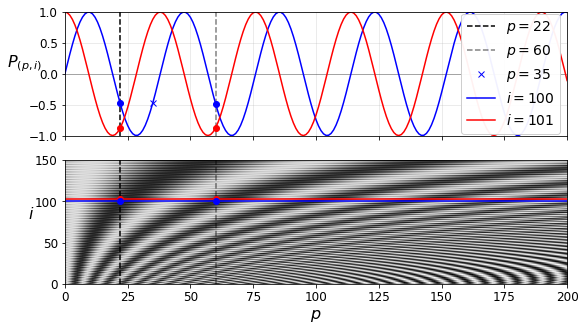

In [73]:
i1, i2, crop_i = 100, 101, 150
p1, p2, p3 = 22, 60, 35
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9, 5))
ax1.plot([p1, p1], [-1, 1], "k--", label="$p = {}$".format(p1))
ax1.plot([p2, p2], [-1, 1], "k--", label="$p = {}$".format(p2), alpha=0.5)
ax1.plot(p3, PE[p3, i1], "bx", label="$p = {}$".format(p3))
ax1.plot(PE[:,i1], "b-", label="$i = {}$".format(i1))
ax1.plot(PE[:,i2], "r-", label="$i = {}$".format(i2))
ax1.plot([p1, p2], [PE[p1, i1], PE[p2, i1]], "bo")
ax1.plot([p1, p2], [PE[p1, i2], PE[p2, i2]], "ro")
ax1.legend(loc="center right", fontsize=14, framealpha=0.95)
ax1.set_ylabel("$P_{(p,i)}$", rotation=0, fontsize=16)
ax1.grid(True, alpha=0.3)
ax1.hlines(0, 0, max_steps - 1, color="k", linewidth=1, alpha=0.3)
ax1.axis([0, max_steps - 1, -1, 1])
ax2.imshow(PE.T[:crop_i], cmap="gray", interpolation="bilinear", aspect="auto")
ax2.hlines(i1, 0, max_steps - 1, color="b")
cheat = 2 # need to raise the red line a bit, or else it hides the blue one
ax2.hlines(i2+cheat, 0, max_steps - 1, color="r")
ax2.plot([p1, p1], [0, crop_i], "k--")
ax2.plot([p2, p2], [0, crop_i], "k--", alpha=0.5)
ax2.plot([p1, p2], [i2+cheat, i2+cheat], "ro")
ax2.plot([p1, p2], [i1, i1], "bo")
ax2.axis([0, max_steps - 1, 0, crop_i])
ax2.set_xlabel("$p$", fontsize=16)
ax2.set_ylabel("$i$", rotation=0, fontsize=16)
save_fig("positional_embedding_plot")
plt.show()

In [74]:
embed_size = 512; max_steps = 500; vocab_size = 10000
encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)
positional_encoding = PositionalEncoding(max_steps, max_dims=embed_size)
encoder_in = positional_encoding(encoder_embeddings)
decoder_in = positional_encoding(decoder_embeddings)

Đây là một Transformer (rất) được đơn giản hóa (kiến trúc thật có các kết nối tắt, chuẩn hóa theo tầng, mạng kết nối dày đặc, và quan trọng nhất là nó sử dụng Tập trung Đa đầu thay vì Tập trung thông thường):

In [75]:
Z = encoder_in
for N in range(6):
    Z = keras.layers.Attention(use_scale=True)([Z, Z])

encoder_outputs = Z
Z = decoder_in
for N in range(6):
    Z = keras.layers.Attention(use_scale=True, causal=True)([Z, Z])
    Z = keras.layers.Attention(use_scale=True)([Z, encoder_outputs])

outputs = keras.layers.TimeDistributed(
    keras.layers.Dense(vocab_size, activation="softmax"))(Z)

Đây là một triển khai cơ bản của tầng `MultiHeadAttention` mà có thể sẽ được thêm vào `keras.layers` trong tương lai gần. Lưu ý các tầng `Conv1D` với `kernel_size=1` (và mặc định `padding="valid"` và `strides=1`) tương đương với một tầng `TimeDistributed(Dense(...))`.

In [76]:
K = keras.backend

class MultiHeadAttention(keras.layers.Layer):
    def __init__(self, n_heads, causal=False, use_scale=False, **kwargs):
        self.n_heads = n_heads
        self.causal = causal
        self.use_scale = use_scale
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.dims = batch_input_shape[0][-1]
        self.q_dims, self.v_dims, self.k_dims = [self.dims // self.n_heads] * 3 # could be hyperparameters instead
        self.q_linear = keras.layers.Conv1D(self.n_heads * self.q_dims, kernel_size=1, use_bias=False)
        self.v_linear = keras.layers.Conv1D(self.n_heads * self.v_dims, kernel_size=1, use_bias=False)
        self.k_linear = keras.layers.Conv1D(self.n_heads * self.k_dims, kernel_size=1, use_bias=False)
        self.attention = keras.layers.Attention(causal=self.causal, use_scale=self.use_scale)
        self.out_linear = keras.layers.Conv1D(self.dims, kernel_size=1, use_bias=False)
        super().build(batch_input_shape)
    def _multi_head_linear(self, inputs, linear):
        shape = K.concatenate([K.shape(inputs)[:-1], [self.n_heads, -1]])
        projected = K.reshape(linear(inputs), shape)
        perm = K.permute_dimensions(projected, [0, 2, 1, 3])
        return K.reshape(perm, [shape[0] * self.n_heads, shape[1], -1])
    def call(self, inputs):
        q = inputs[0]
        v = inputs[1]
        k = inputs[2] if len(inputs) > 2 else v
        shape = K.shape(q)
        q_proj = self._multi_head_linear(q, self.q_linear)
        v_proj = self._multi_head_linear(v, self.v_linear)
        k_proj = self._multi_head_linear(k, self.k_linear)
        multi_attended = self.attention([q_proj, v_proj, k_proj])
        shape_attended = K.shape(multi_attended)
        reshaped_attended = K.reshape(multi_attended, [shape[0], self.n_heads, shape_attended[1], shape_attended[2]])
        perm = K.permute_dimensions(reshaped_attended, [0, 2, 1, 3])
        concat = K.reshape(perm, [shape[0], shape_attended[1], -1])
        return self.out_linear(concat)

In [77]:
Q = np.random.rand(2, 50, 512)
V = np.random.rand(2, 80, 512)
multi_attn = MultiHeadAttention(8)
multi_attn([Q, V]).shape


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



TensorShape([2, 50, 512])

# Lời giải bài tập

## 1. to 7.

Xem Phụ lục A.

## 8.
_Bài tập:_ Ngữ pháp đại diện Reber (Embedded Reber grammars) _được sử dụng bởi Hochreiter và Schmidhuber trong [bài báo của họ](https://homl.info/93) về LSTM. Đó là ngữ pháp giả để tạo ra những chuỗi như "BPBTSXXVPSEPE." Xem thêm [bài giới thiệu hay](https://homl.info/108) về chủ đề này của Jenny Orr. Hãy chọn một ngữ pháp đại diện Reber cụ thể (ví dụ như ngữ pháp được giới thiệu trong bài viết của Jenny Orr), tiếp đó huấn luyện một RNN để nhận diện xem chuỗi có tuân theo ngữ pháp đó hay không. Đầu tiên ta cần viết một hàm để tạo một batch huấn luyện chứa khoảng 50\% các chuỗi tuân theo ngữ pháp, và 50\% các chuỗi không tuân theo ngữ pháp._

Đầu tiên ta cần tạo một hàm để tạo các chuỗi dựa trên ngữ pháp. Ngữ pháp sẽ được trình bày như một danh sách của các chuyển đổi có thể cho mỗi trạng thái. Một chuyển đổi chỉ định chuỗi cần xuất (hoặc ngữ pháp để tạo ra chuỗi đó) và trạng thái tiếp theo.

In [78]:
default_reber_grammar = [
    [("B", 1)],           # (state 0) =B=>(state 1)
    [("T", 2), ("P", 3)], # (state 1) =T=>(state 2) or =P=>(state 3)
    [("S", 2), ("X", 4)], # (state 2) =S=>(state 2) or =X=>(state 4)
    [("T", 3), ("V", 5)], # and so on...
    [("X", 3), ("S", 6)],
    [("P", 4), ("V", 6)],
    [("E", None)]]        # (state 6) =E=>(terminal state)

embedded_reber_grammar = [
    [("B", 1)],
    [("T", 2), ("P", 3)],
    [(default_reber_grammar, 4)],
    [(default_reber_grammar, 5)],
    [("T", 6)],
    [("P", 6)],
    [("E", None)]]

def generate_string(grammar):
    state = 0
    output = []
    while state is not None:
        index = np.random.randint(len(grammar[state]))
        production, state = grammar[state][index]
        if isinstance(production, list):
            production = generate_string(grammar=production)
        output.append(production)
    return "".join(output)

Hãy tạo một số chuỗi dựa trên ngữ pháp Reber mặc định:

In [79]:
np.random.seed(42)

for _ in range(25):
    print(generate_string(default_reber_grammar), end=" ")

BTXXTTVPXTVPXTTVPSE BPVPSE BTXSE BPVVE BPVVE BTSXSE BPTVPXTTTVVE BPVVE BTXSE BTXXVPSE BPTTTTTTTTVVE BTXSE BPVPSE BTXSE BPTVPSE BTXXTVPSE BPVVE BPVVE BPVVE BPTTVVE BPVVE BPVVE BTXXVVE BTXXVVE BTXXVPXVVE 

Có vẻ ổn! Bây giờ hãy tạo một số chuỗi duwaj trên ngữ pháp đại diện Reber:

In [80]:
np.random.seed(42)

for _ in range(25):
    print(generate_string(embedded_reber_grammar), end=" ")

BTBPTTTVPXTVPXTTVPSETE BPBPTVPSEPE BPBPVVEPE BPBPVPXVVEPE BPBTXXTTTTVVEPE BPBPVPSEPE BPBTXXVPSEPE BPBTSSSSSSSXSEPE BTBPVVETE BPBTXXVVEPE BPBTXXVPSEPE BTBTXXVVETE BPBPVVEPE BPBPVVEPE BPBTSXSEPE BPBPVVEPE BPBPTVPSEPE BPBTXXVVEPE BTBPTVPXVVETE BTBPVVETE BTBTSSSSSSSXXVVETE BPBTSSSXXTTTTVPSEPE BTBPTTVVETE BPBTXXTVVEPE BTBTXSETE 

Ổn rồi, bây giờ ta cần một hàm để tạo các chuỗi không tuân theo ngữ pháp. Ta có thể tạo một chuỗi ngẫu nhiên, nhưng tác vụ sẽ hơi dễ một chút, vì vậy ta sẽ tạo một chuỗi tuân theo ngữ pháp, và ta sẽ phá nó bằng cách chỉ thay thế chỉ một ký tự:

In [81]:
POSSIBLE_CHARS = "BEPSTVX"

def generate_corrupted_string(grammar, chars=POSSIBLE_CHARS):
    good_string = generate_string(grammar)
    index = np.random.randint(len(good_string))
    good_char = good_string[index]
    bad_char = np.random.choice(sorted(set(chars) - set(good_char)))
    return good_string[:index] + bad_char + good_string[index + 1:]

Hãy xem một số chuỗi bị phá cấu trúc ngữ pháp:

In [82]:
np.random.seed(42)

for _ in range(25):
    print(generate_corrupted_string(embedded_reber_grammar), end=" ")

BTBPTTTPPXTVPXTTVPSETE BPBTXEEPE BPBPTVVVEPE BPBTSSSSXSETE BPTTXSEPE BTBPVPXTTTTTTEVETE BPBTXXSVEPE BSBPTTVPSETE BPBXVVEPE BEBTXSETE BPBPVPSXPE BTBPVVVETE BPBTSXSETE BPBPTTTPTTTTTVPSEPE BTBTXXTTSTVPSETE BBBTXSETE BPBTPXSEPE BPBPVPXTTTTVPXTVPXVPXTTTVVEVE BTBXXXTVPSETE BEBTSSSSSXXVPXTVVETE BTBXTTVVETE BPBTXSTPE BTBTXXTTTVPSBTE BTBTXSETX BTBTSXSSTE 

Ta không thể đưa các chuỗi trực tiếp vào một RNN, vì thế ta cần mã hóa chúng bằng cách nào đó. Một lựa chọn khả thi là biểu diễn one-hot cho mỗi ký tự. Một lựa chọn khác là sử dụng embedding. Hãy thử với lựa chọn thứ hai (nhưng vì chỉ có một số ít ký ự, biểu diễn one-hot cũng có thể là một lựa chọn tốt). Để embedding hoạt động, ta cần chuyển mỗi chuỗi thành chuỗi các ID ký tự. Hãy viết một hàm để làm điều đó, sử dụng chỉ số của mỗi ký tự trong chuỗi gồm các ký tự có thể "BEPSTVX":

In [83]:
def string_to_ids(s, chars=POSSIBLE_CHARS):
    return [chars.index(c) for c in s]

In [84]:
string_to_ids("BTTTXXVVETE")

[0, 4, 4, 4, 6, 6, 5, 5, 1, 4, 1]

Bây giờ ta có thể tạo bộ dữ liệu, với 50% các chuổi đúng và 50% các chuỗi sai:

In [85]:
def generate_dataset(size):
    good_strings = [string_to_ids(generate_string(embedded_reber_grammar))
                    for _ in range(size // 2)]
    bad_strings = [string_to_ids(generate_corrupted_string(embedded_reber_grammar))
                   for _ in range(size - size // 2)]
    all_strings = good_strings + bad_strings
    X = tf.ragged.constant(all_strings, ragged_rank=1)
    y = np.array([[1.] for _ in range(len(good_strings))] +
                 [[0.] for _ in range(len(bad_strings))])
    return X, y

In [86]:
np.random.seed(42)

X_train, y_train = generate_dataset(10000)
X_valid, y_valid = generate_dataset(2000)

Hãy xem chuỗi huấn luyện đầu tiên:

In [87]:
X_train[0]

<tf.Tensor: shape=(22,), dtype=int32, numpy=
array([0, 4, 0, 2, 4, 4, 4, 5, 2, 6, 4, 5, 2, 6, 4, 4, 5, 2, 3, 1, 4, 1],
      dtype=int32)>

Nó thuộc lớp nào?

In [88]:
y_train[0]

array([1.])

Hoàn hảo! Ta đã sẵn sàng để tạo RNN nhằm xác định các chuỗi đúng. Ta xây dựng một bộ phân loại chuỗi nhị phân đơn giản:

In [89]:
np.random.seed(42)
tf.random.set_seed(42)

embedding_size = 5

model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[None], dtype=tf.int32, ragged=True),
    keras.layers.Embedding(input_dim=len(POSSIBLE_CHARS), output_dim=embedding_size),
    keras.layers.GRU(30),
    keras.layers.Dense(1, activation="sigmoid")
])
optimizer = keras.optimizers.SGD(learning_rate=0.02, momentum = 0.95, nesterov=True)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20


/Users/ageron/miniconda3/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Users/ageron/miniconda3/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


313/313 [========================================================================================================================================================================================================================================================================================================================================================================] - 5s 42us/sample - loss: 0.6847 - accuracy: 0.5138 - val_loss: 8.1518 - val_accuracy: 0.6115
Epoch 2/20
313/313 [========================================================================================================================================================================================================================================================================================================================================================================] - 3s 28us/sample - loss: 0.6524 - accuracy: 0.5571 - val_loss: 7.9259 - val_accuracy: 0.6085
Epoch 3/20
313/313 [=========================================

Bây giờ hãy kiểm tra RNN của bạn trên hai chuỗi phức tạp: chuỗi đầu sai trong khi chuỗi thứ hai đúng. Chúng chỉ khác nhau ở ký tự kế cuối. Nếu RNN đoán đúng, mô hình đã có thể chú ý đến mẫu mà chữ cái thứ hai luôn phải giống chữ cái kế cuối. Điều này đòi hỏi một bộ nhớ ngắn hạn khá dài (đó là lý do vì sao ta dùng GRU).

In [90]:
test_strings = ["BPBTSSSSSSSXXTTVPXVPXTTTTTVVETE",
                "BPBTSSSSSSSXXTTVPXVPXTTTTTVVEPE"]
X_test = tf.ragged.constant([string_to_ids(s) for s in test_strings], ragged_rank=1)

y_proba = model.predict(X_test)
print()
print("Estimated probability that these are Reber strings:")
for index, string in enumerate(test_strings):
    print("{}: {:.2f}%".format(string, 100 * y_proba[index][0]))


Estimated probability that these are Reber strings:
BPBTSSSSSSSXXTTVPXVPXTTTTTVVETE: 0.40%
BPBTSSSSSSSXXTTVPXVPXTTTTTVVEPE: 99.96%


Nó hoạt động tốt. RNN tìm ra các câu trả lời đúng với độ tin cậy cao. :)

## 9.
_Bài tập: Huấn luyện một mô hình Mã hóa - Dịch mã để chuyển một chuỗi ngày tháng từ một định dạng sang một định dạng khác (ví dụ, từ "April 22, 2019" thành "2019-04-22")._

Hãy bắt đầu tạo tập dữ liệu. Ta sẽ dữ dụng các ngày ngẫu nhiên giữa 1000-01-01 và 9999-12-31:

In [91]:
from datetime import date

# cannot use strftime()'s %B format since it depends on the locale
MONTHS = ["January", "February", "March", "April", "May", "June",
          "July", "August", "September", "October", "November", "December"]

def random_dates(n_dates):
    min_date = date(1000, 1, 1).toordinal()
    max_date = date(9999, 12, 31).toordinal()

    ordinals = np.random.randint(max_date - min_date, size=n_dates) + min_date
    dates = [date.fromordinal(ordinal) for ordinal in ordinals]

    x = [MONTHS[dt.month - 1] + " " + dt.strftime("%d, %Y") for dt in dates]
    y = [dt.isoformat() for dt in dates]
    return x, y

Đây là một số ngày ngẫu nhiên, được hiển thị cả định dạng đầu vào và định dạng đầu ra:

In [92]:
np.random.seed(42)

n_dates = 3
x_example, y_example = random_dates(n_dates)
print("{:25s}{:25s}".format("Input", "Target"))
print("-" * 50)
for idx in range(n_dates):
    print("{:25s}{:25s}".format(x_example[idx], y_example[idx]))

Input                    Target                   
--------------------------------------------------
September 20, 7075       7075-09-20               
May 15, 8579             8579-05-15               
January 11, 7103         7103-01-11               


Hãy thu danh sách của tất cả các ký thị có thể trong đầu vào:

In [93]:
INPUT_CHARS = "".join(sorted(set("".join(MONTHS) + "0123456789, ")))
INPUT_CHARS

' ,0123456789ADFJMNOSabceghilmnoprstuvy'

Và đây là danh sách của các ký tự có thể trong đầu ra:

In [94]:
OUTPUT_CHARS = "0123456789-"

Hãy viết một hàm để chuyển một chuỗi thành danh sách các ID ký tự, như ta đã làm ở bài tập trước:

In [95]:
def date_str_to_ids(date_str, chars=INPUT_CHARS):
    return [chars.index(c) for c in date_str]

In [96]:
date_str_to_ids(x_example[0], INPUT_CHARS)

[7, 11, 19, 22, 11, 16, 9, 11, 20, 38, 28, 26, 37, 38, 33, 26, 33, 31]

In [97]:
date_str_to_ids(y_example[0], OUTPUT_CHARS)

[7, 0, 7, 5, 10, 0, 9, 10, 2, 0]

In [98]:
def prepare_date_strs(date_strs, chars=INPUT_CHARS):
    X_ids = [date_str_to_ids(dt, chars) for dt in date_strs]
    X = tf.ragged.constant(X_ids, ragged_rank=1)
    return (X + 1).to_tensor() # using 0 as the padding token ID

def create_dataset(n_dates):
    x, y = random_dates(n_dates)
    return prepare_date_strs(x, INPUT_CHARS), prepare_date_strs(y, OUTPUT_CHARS)

In [99]:
np.random.seed(42)

X_train, Y_train = create_dataset(10000)
X_valid, Y_valid = create_dataset(2000)
X_test, Y_test = create_dataset(2000)

In [100]:
Y_train[0]

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([ 8,  1,  8,  6, 11,  1, 10, 11,  3,  1], dtype=int32)>

### Phiên bản đầu tiên: một mô hình seq2seq rất cơ bản

Đầu tiên hãy thử mô hình đơn giản nhất có thể: ta đưa vào chuỗi đầu vào mà đầu tiên sẽ đi qua bộ mã hóa (một tầng embedding theo sau bởi một tầng LSTM đơn) và xuất ra một vector, tiếp đó đi qua một bộ giải mã (một tầng LSTM đơn, theo sau bởi một tầng đầu ra kết nối dày đặc) và xuất ra một chuỗi các vector, mỗi vector đại diện xác suất ước tính cho tất cả các ký tự đầu ra có thể.

Vì bộ giải mã cần một chuỗi làm đầu vào, ta lặp lại vector (do bộ mã hóa xuất ra) nhiều lần bằng chuỗi đầu ra dài nhất có thể.

In [101]:
embedding_size = 32
max_output_length = Y_train.shape[1]

np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([
    keras.layers.Embedding(input_dim=len(INPUT_CHARS) + 1,
                           output_dim=embedding_size,
                           input_shape=[None]),
    keras.layers.LSTM(128)
])

decoder = keras.models.Sequential([
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.Dense(len(OUTPUT_CHARS) + 1, activation="softmax")
])

model = keras.models.Sequential([
    encoder,
    keras.layers.RepeatVector(max_output_length),
    decoder
])

optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
313/313 [==============================] - 6s 18ms/step - loss: 1.8111 - accuracy: 0.3533 - val_loss: 1.3581 - val_accuracy: 0.4965
Epoch 2/20
313/313 [==============================] - 5s 15ms/step - loss: 1.3518 - accuracy: 0.5103 - val_loss: 1.1915 - val_accuracy: 0.5694
Epoch 3/20
313/313 [==============================] - 5s 15ms/step - loss: 1.1706 - accuracy: 0.5908 - val_loss: 0.9983 - val_accuracy: 0.6398
Epoch 4/20
313/313 [==============================] - 5s 15ms/step - loss: 0.9158 - accuracy: 0.6686 - val_loss: 0.8012 - val_accuracy: 0.6987
Epoch 5/20
313/313 [==============================] - 5s 15ms/step - loss: 0.7058 - accuracy: 0.7308 - val_loss: 0.6224 - val_accuracy: 0.7599
Epoch 6/20
313/313 [==============================] - 5s 15ms/step - loss: 0.7756 - accuracy: 0.7203 - val_loss: 0.6541 - val_accuracy: 0.7599
Epoch 7/20
313/313 [==============================] - 5s 16ms/step - loss: 0.5379 - accuracy: 0.8034 - val_loss: 0.4174 - val_accuracy: 0.8440

Tuyệt vời! Ta đạt độ chính xác kiểm định 100%! Hãy sử dụng mô hình để dự đoán. Ta cần chuyển một chuỗi ID ký tự thành một chuỗi có thể đọc được:

In [102]:
def ids_to_date_strs(ids, chars=OUTPUT_CHARS):
    return ["".join([("?" + chars)[index] for index in sequence])
            for sequence in ids]

Bây giờ ta có thể sử dụng mô hình để chuyển một số ngày

In [103]:
X_new = prepare_date_strs(["September 17, 2009", "July 14, 1789"])

In [104]:
#ids = model.predict_classes(X_new)
ids = np.argmax(model.predict(X_new), axis=-1)
for date_str in ids_to_date_strs(ids):
    print(date_str)

2009-09-17
1789-07-14


Hoàn hảo! :)

Tuy nhiên, vì mô hình chỉ được huấn luyện trên chuỗi đầu vào có độ dài 18 (độ dài dài nhất của định dạng ngày), mô hình không biểu hiện tốt nếu ta sử dụng để dự đoán chuỗi ngắn hơn.

In [105]:
X_new = prepare_date_strs(["May 02, 2020", "July 14, 1789"])

In [106]:
#ids = model.predict_classes(X_new)
ids = np.argmax(model.predict(X_new), axis=-1)
for date_str in ids_to_date_strs(ids):
    print(date_str)

2020-01-02
1789-02-14


Oops! Ta cần đảm bảo rằng ta luôn truyền các chuỗi có độ dài bằng nhau trong quá trình huấn luyện, sử dụng đệm nếu cần thiết. Hãy viết một hàm hỗ trợ đơn giản để làm việc đó:

In [107]:
max_input_length = X_train.shape[1]

def prepare_date_strs_padded(date_strs):
    X = prepare_date_strs(date_strs)
    if X.shape[1] < max_input_length:
        X = tf.pad(X, [[0, 0], [0, max_input_length - X.shape[1]]])
    return X

def convert_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    #ids = model.predict_classes(X)
    ids = np.argmax(model.predict(X), axis=-1)
    return ids_to_date_strs(ids)

In [108]:
convert_date_strs(["May 02, 2020", "July 14, 1789"])

['2020-05-02', '1789-07-14']

Tuyệt! Đúng là chắc chắn có nhiều cách đơn giản hơn để viết một công cụ chuyển đổi định dạng ngày (ví dụ: sử dụng biểu thức chính quy hoặc thậm chí thao tác chuỗi cơ bản), nhưng bạn phải thừa nhận rằng sử dụng mạng nơ-ron thú vị hơn nhiều. ;-)

Tuy nhiên, các vấn đề chuỗi sang chuỗi trong thực tế thường sẽ khó hơn, vì vậy để hoàn thiện, hãy xây dựng mộ mô hình mạnh hơn.

### Phiên bản thứ hai: cung cấp các mục tiêu đã bị dịch chuyển cho bộ giải mã (teacher forcing)

Thay vì đưa vào bộ giải mã một sự lặp lại đơn giản của các vector đầu ra của bộ mã hóa, ta có thể cung cấp cho bộ giải mã chuỗi mục tiêu được dịch chuyển một bước thời gian. Bằng cách này, tại mỗi bước, bộ giải mã sẽ biết ký tự mục tiêu trước đó là gì. Điều này sẽ giúp giải quyết các vấn đề chuỗi sang chuỗi phức tạp hơn.

Vì ký tự đầu ra đầu tiên của mỗi chuỗi mục tiêu không có ký tự trước đó, ta sẽ cần một token mới để đại diện bắt đầu chuỗi (sos).

Trong suốt quá trình dự đoán, ta sẽ không biết chuỗi mục tiêu, vậy thì ta sẽ truyền gì vào bộ giải mã? Ta có thể chỉ dự đoán một ký tự tại một thời điểm, bắt đầu bằng token sos, sau đó cung cấp cho bộ giải mã tất cả các ký tự đã được dự đoán cho đến thời điểm đó (ta sẽ xem quá trình này chi tiết hơn ở phần sau của notebook này).

Nhưng nếu LSTM của bộ giải mã cần lấy mục tiêu trước đó làm đầu vào ở mỗi bước, làm sao ta có thể truyền nó vào vector xuất ra bởi bộ mã hóa? Vâng, một giải pháp là bỏ qua vector đầu ra, và thay vì vậy, sử dụng trạng thái LSTM của bộ mã hóa như trạng thái ban đầu của LSTM cho bộ giải mã (điều này yêu cầu LSTM của bộ giải mã cần có cùng số lượng nút với LSTM của bộ mã hóa).

Bây giờ hãy tạo đầu vào cho bộ giải mã (để huấn luyện, thẩm định và kiểm tra). Token sos sẽ được biểu diễn bằng ID của ký tự đầu ra cuối cùng + 1.

In [109]:
sos_id = len(OUTPUT_CHARS) + 1

def shifted_output_sequences(Y):
    sos_tokens = tf.fill(dims=(len(Y), 1), value=sos_id)
    return tf.concat([sos_tokens, Y[:, :-1]], axis=1)

X_train_decoder = shifted_output_sequences(Y_train)
X_valid_decoder = shifted_output_sequences(Y_valid)
X_test_decoder = shifted_output_sequences(Y_test)

Hãy xem đầu vào huấn luyện của bộ giải mã:

In [110]:
X_train_decoder

<tf.Tensor: shape=(10000, 10), dtype=int32, numpy=
array([[12,  8,  1, ..., 10, 11,  3],
       [12,  9,  6, ...,  6, 11,  2],
       [12,  8,  2, ...,  2, 11,  2],
       ...,
       [12, 10,  8, ...,  2, 11,  4],
       [12,  2,  2, ...,  3, 11,  3],
       [12,  8,  9, ...,  8, 11,  3]], dtype=int32)>

Bây giờ hãy xây dựng mô hình. Mô hình không còn là một mô hình tuần tự đơn giản nữa, vì vậy hãy sử dụng API:

In [111]:
encoder_embedding_size = 32
decoder_embedding_size = 32
lstm_units = 128

np.random.seed(42)
tf.random.set_seed(42)

encoder_input = keras.layers.Input(shape=[None], dtype=tf.int32)
encoder_embedding = keras.layers.Embedding(
    input_dim=len(INPUT_CHARS) + 1,
    output_dim=encoder_embedding_size)(encoder_input)
_, encoder_state_h, encoder_state_c = keras.layers.LSTM(
    lstm_units, return_state=True)(encoder_embedding)
encoder_state = [encoder_state_h, encoder_state_c]

decoder_input = keras.layers.Input(shape=[None], dtype=tf.int32)
decoder_embedding = keras.layers.Embedding(
    input_dim=len(OUTPUT_CHARS) + 2,
    output_dim=decoder_embedding_size)(decoder_input)
decoder_lstm_output = keras.layers.LSTM(lstm_units, return_sequences=True)(
    decoder_embedding, initial_state=encoder_state)
decoder_output = keras.layers.Dense(len(OUTPUT_CHARS) + 1,
                                    activation="softmax")(decoder_lstm_output)

model = keras.models.Model(inputs=[encoder_input, decoder_input],
                           outputs=[decoder_output])

optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit([X_train, X_train_decoder], Y_train, epochs=10,
                    validation_data=([X_valid, X_valid_decoder], Y_valid))

Epoch 1/10
313/313 [==============================] - 5s 17ms/step - loss: 1.6898 - accuracy: 0.3714 - val_loss: 1.4141 - val_accuracy: 0.4603
Epoch 2/10
313/313 [==============================] - 5s 15ms/step - loss: 1.2118 - accuracy: 0.5541 - val_loss: 0.9360 - val_accuracy: 0.6653
Epoch 3/10
313/313 [==============================] - 5s 15ms/step - loss: 0.6399 - accuracy: 0.7766 - val_loss: 0.4054 - val_accuracy: 0.8631
Epoch 4/10
313/313 [==============================] - 5s 15ms/step - loss: 0.2207 - accuracy: 0.9463 - val_loss: 0.1069 - val_accuracy: 0.9869
Epoch 5/10
313/313 [==============================] - 5s 15ms/step - loss: 0.0805 - accuracy: 0.9910 - val_loss: 0.0445 - val_accuracy: 0.9976
Epoch 6/10
313/313 [==============================] - 5s 15ms/step - loss: 0.0297 - accuracy: 0.9993 - val_loss: 0.0237 - val_accuracy: 0.9992
Epoch 7/10
313/313 [==============================] - 5s 15ms/step - loss: 0.0743 - accuracy: 0.9857 - val_loss: 0.0702 - val_accuracy: 0.9889

Mô hình này cũng đạt được 100% độ chính xác thẩm định sau ít thời gian hơn mô hình trước.

Hãy sử dụng mô hình để dự đoán. Lần này ta cần dự đoán từng ký tự một.

In [112]:
sos_id = len(OUTPUT_CHARS) + 1

def predict_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    Y_pred = tf.fill(dims=(len(X), 1), value=sos_id)
    for index in range(max_output_length):
        pad_size = max_output_length - Y_pred.shape[1]
        X_decoder = tf.pad(Y_pred, [[0, 0], [0, pad_size]])
        Y_probas_next = model.predict([X, X_decoder])[:, index:index+1]
        Y_pred_next = tf.argmax(Y_probas_next, axis=-1, output_type=tf.int32)
        Y_pred = tf.concat([Y_pred, Y_pred_next], axis=1)
    return ids_to_date_strs(Y_pred[:, 1:])

In [113]:
predict_date_strs(["July 14, 1789", "May 01, 2020"])

['1789-07-14', '2020-05-01']

Hoạt động tốt! :)

### Phiên bản thứ ba: sử dụng triển khai seq2seq của TF-Addon

Hãy xây dựng một mô hình như trên nhưng sử dụng API seq2seq của TF-Addon. Triển khai dưới đây hầu như rất tương tự với ví dụ TFA ở phần trên của notebook, ngoại trừ không có đầu vào mô hình để chỉ định độ dài đầu ra, cho đơn giản (nhưng bạn có thể dễ dàng thêm nó sau đó nếu bạn cần cho các dự án của mình, khi các chuỗi đầu ra có các độ dài rất khác nhau).

In [114]:
import tensorflow_addons as tfa

np.random.seed(42)
tf.random.set_seed(42)

encoder_embedding_size = 32
decoder_embedding_size = 32
units = 128

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

encoder_embeddings = keras.layers.Embedding(
    len(INPUT_CHARS) + 1, encoder_embedding_size)(encoder_inputs)

decoder_embedding_layer = keras.layers.Embedding(
    len(OUTPUT_CHARS) + 2, decoder_embedding_size)
decoder_embeddings = decoder_embedding_layer(decoder_inputs)

encoder = keras.layers.LSTM(units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.TrainingSampler()

decoder_cell = keras.layers.LSTMCell(units)
output_layer = keras.layers.Dense(len(OUTPUT_CHARS) + 1)

decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell,
                                                 sampler,
                                                 output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings,
    initial_state=encoder_state)
Y_proba = keras.layers.Activation("softmax")(final_outputs.rnn_output)

model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs],
                           outputs=[Y_proba])
optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit([X_train, X_train_decoder], Y_train, epochs=15,
                    validation_data=([X_valid, X_valid_decoder], Y_valid))

Epoch 1/15
313/313 [==============================] - 5s 17ms/step - loss: 1.6757 - accuracy: 0.3683 - val_loss: 1.4602 - val_accuracy: 0.4214
Epoch 2/15
313/313 [==============================] - 5s 15ms/step - loss: 1.3873 - accuracy: 0.4566 - val_loss: 1.2904 - val_accuracy: 0.4957
Epoch 3/15
313/313 [==============================] - 5s 15ms/step - loss: 1.0471 - accuracy: 0.6109 - val_loss: 0.7737 - val_accuracy: 0.7276
Epoch 4/15
313/313 [==============================] - 5s 15ms/step - loss: 0.5056 - accuracy: 0.8296 - val_loss: 0.2695 - val_accuracy: 0.9305
Epoch 5/15
313/313 [==============================] - 5s 15ms/step - loss: 0.1677 - accuracy: 0.9657 - val_loss: 0.0870 - val_accuracy: 0.9912
Epoch 6/15
313/313 [==============================] - 5s 15ms/step - loss: 0.1007 - accuracy: 0.9850 - val_loss: 0.0492 - val_accuracy: 0.9975
Epoch 7/15
313/313 [==============================] - 5s 15ms/step - loss: 0.0308 - accuracy: 0.9993 - val_loss: 0.0228 - val_accuracy: 0.9996

Và một lần nữa, độ chính xác thẩm định 100%. Để sử dụng mô hình, ta chỉ cần tái sử dụng hàm `predict_date_strs()`:

In [115]:
predict_date_strs(["July 14, 1789", "May 01, 2020"])

['1789-07-14', '2020-05-01']

Tuy nhiên, có một cách hiệu quả hơn để dự đoán. Cho đến hiện tại, trong khi dự đoán, ta chạy mô hình một lần cho mỗi ký tự mới. Thay vào đó, ta có thể tạo một bộ giải mã mới, dựa trên các tầng đã huấn luyện trước đó, nhưng sử dụng `GreedyEmbeddingSampler` thay vì `TrainingSampler`.

Tại mỗi bước thời gian, `GreedyEmbeddingSampler` sẽ tính argmax của đầu ra từ bộ giải mã, và chạy ID của token được xuất ra thông qua tầng embedding của bộ giải mã. Tiếp đó nó sẽ truyền embedding kết quả vào ô LSTM của bộ giải mã tại mỗi bước thời gian. Bằng cách này ta chỉ cần chạy bộ giải mã một lần để thu được dự đoán đầy đủ.

In [116]:
inference_sampler = tfa.seq2seq.sampler.GreedyEmbeddingSampler(
    embedding_fn=decoder_embedding_layer)
inference_decoder = tfa.seq2seq.basic_decoder.BasicDecoder(
    decoder_cell, inference_sampler, output_layer=output_layer,
    maximum_iterations=max_output_length)
batch_size = tf.shape(encoder_inputs)[:1]
start_tokens = tf.fill(dims=batch_size, value=sos_id)
final_outputs, final_state, final_sequence_lengths = inference_decoder(
    start_tokens,
    initial_state=encoder_state,
    start_tokens=start_tokens,
    end_token=0)

inference_model = keras.models.Model(inputs=[encoder_inputs],
                                     outputs=[final_outputs.sample_id])

Một vài lưu ý:
* `GreedyEmbeddingSampler` cần `start_tokens` (một vector chứa ID bắt đầu chuỗi cho mỗi chuỗi giải mã), và `end_token` (bộ giải mã sẽ dừng giải mã một chuỗi một khi mô hình xuất ra token này).
* Ta cần cài đặt `maximum_iterations` khi tạo `BasicDecoder`, nếu không nó có thể chạy vào một vòng lặp vô tận (nếu mô hình không bao giờ xuất ra token kết thúc cho ít nhất một trong các chuỗi). Điều này buộc bạn phải khởi động lại kernel Jupyter.
* Đầu vào của bộ giải mã không còn cần thiết nữa vì tất cả đầu vào của bộ giải mã đã được tạo động dựa trên các đầu ra từ bước thời gian trước đó.
* Đầu ra của mô hình là `final_outputs.sample_id` thay vì là softmax của `final_outputs.rnn_outputs`. Điều này cho phép ta trực tiếp thu argmax đầu ra của mô hình. Nếu bạn muốn có giá trị logits, bạn có thể thay `final_outputs.sample_id` với `final_outputs.rnn_outputs`.

Bây giờ ta có thể viết một hàm đơn giản sử dụng mô hình để thực hiện chuyển đổi định dạng ngày:

In [117]:
def fast_predict_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    Y_pred = inference_model.predict(X)
    return ids_to_date_strs(Y_pred)

In [118]:
fast_predict_date_strs(["July 14, 1789", "May 01, 2020"])

['1789-07-14', '2020-05-01']

Hãy kiểm tra xem nó có thực sự nhanh hơn:

In [119]:
%timeit predict_date_strs(["July 14, 1789", "May 01, 2020"])

199 ms ± 3.94 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [120]:
%timeit fast_predict_date_strs(["July 14, 1789", "May 01, 2020"])

18.3 ms ± 366 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Nhanh hơn đến 10 lần! Và nó thậm chí sẽ nhanh hơn nếu ta xử lý chuỗi dài hơn.

### Phiên bản thứ tư: sử dụng triển khai seq2seq của TF-Addon với một bộ lấy mẫu theo lịch trình

**Cảnh báo**: vì một lỗi TF, phiên bản này chỉ hoạt động với TensorFlow 2.2 trở lên.

Khi ta huấn luyện mô hình ở trên, mỗi bước thời gian _t_ ta truyền token mục tiêu cho bước thời gian _t_ - 1 vào mô hình. Tuy nhiên, khi dự đoán, mô hình không nhận được mục tiêu trước đó ở mỗi bước thời gian. Thay vào đó, mô hình nhận dự đoán trước đó. Vì vậy, có sự khác biệt giữa huấn luyện và dự đoán, và có thể dẫn đến kết quả đáng thất vọng. Để giảm thiểu điều này, ta có thể từ từ thay mục tiêu với dự đoán trong quá trình huấn luyện. Cho việc này, ta chỉ cần thay `TrainingSampler` với `ScheduledEmbeddingTrainingSampler`, và sử dụng callback Keras để dần tăng `sampling_probability` (nghĩa là xác suất bộ giải mã sẽ nhận dự đoán từ bước thời gian trước đó thay vì mục tiêu cho bước thời gian trước đó).

In [121]:
import tensorflow_addons as tfa

np.random.seed(42)
tf.random.set_seed(42)

n_epochs = 20
encoder_embedding_size = 32
decoder_embedding_size = 32
units = 128

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

encoder_embeddings = keras.layers.Embedding(
    len(INPUT_CHARS) + 1, encoder_embedding_size)(encoder_inputs)

decoder_embedding_layer = keras.layers.Embedding(
    len(OUTPUT_CHARS) + 2, decoder_embedding_size)
decoder_embeddings = decoder_embedding_layer(decoder_inputs)

encoder = keras.layers.LSTM(units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.ScheduledEmbeddingTrainingSampler(
    sampling_probability=0.,
    embedding_fn=decoder_embedding_layer)
# we must set the sampling_probability after creating the sampler
# (see https://github.com/tensorflow/addons/pull/1714)
sampler.sampling_probability = tf.Variable(0.)

decoder_cell = keras.layers.LSTMCell(units)
output_layer = keras.layers.Dense(len(OUTPUT_CHARS) + 1)

decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell,
                                                 sampler,
                                                 output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings,
    initial_state=encoder_state)
Y_proba = keras.layers.Activation("softmax")(final_outputs.rnn_output)

model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs],
                           outputs=[Y_proba])
optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

def update_sampling_probability(epoch, logs):
    proba = min(1.0, epoch / (n_epochs - 10))
    sampler.sampling_probability.assign(proba)

sampling_probability_cb = keras.callbacks.LambdaCallback(
    on_epoch_begin=update_sampling_probability)
history = model.fit([X_train, X_train_decoder], Y_train, epochs=n_epochs,
                    validation_data=([X_valid, X_valid_decoder], Y_valid),
                    callbacks=[sampling_probability_cb])

Epoch 1/20


/Users/ageron/miniconda3/envs/tf2/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


313/313 [==============================] - 6s 19ms/step - loss: 1.6759 - accuracy: 0.3681 - val_loss: 1.4611 - val_accuracy: 0.4198
Epoch 2/20
313/313 [==============================] - 5s 17ms/step - loss: 1.3872 - accuracy: 0.4583 - val_loss: 1.2827 - val_accuracy: 0.5021
Epoch 3/20
313/313 [==============================] - 5s 17ms/step - loss: 1.0425 - accuracy: 0.6152 - val_loss: 0.8165 - val_accuracy: 0.7000
Epoch 4/20
313/313 [==============================] - 5s 17ms/step - loss: 0.6353 - accuracy: 0.7673 - val_loss: 0.4365 - val_accuracy: 0.8464
Epoch 5/20
313/313 [==============================] - 5s 17ms/step - loss: 0.3764 - accuracy: 0.8765 - val_loss: 0.2795 - val_accuracy: 0.9166
Epoch 6/20
313/313 [==============================] - 5s 17ms/step - loss: 0.2506 - accuracy: 0.9269 - val_loss: 0.1805 - val_accuracy: 0.9489
Epoch 7/20
313/313 [==============================] - 5s 17ms/step - loss: 0.1427 - accuracy: 0.9625 - val_loss: 0.1115 - val_accuracy: 0.9718
Epoch 8/20

Độ chính xác thẩm định không hoàn toàn 100%, nhưng rất gần con số đó!

Để dự đoán, ta có thể thực hiện giống như đã làm ở trên, sử dụng `GreedyEmbeddingSampler`. Tuy nhiên, chỉ với mục đích hoàn chỉnh, thay vào đó hãy sử dụng một `SampleEmbeddingSampler`. Nó hầu như giống với triển khai trước, ngoài việc thay vì sử dụng argmax của đầu ra mô hình để tìm ID token, nó xử lý đầu ra như logits và sử dụng chúng để lấy mẫu một ID token ngẫu nhiên. Việc này có thể hữu ích khi bạn muốn tạo ra văn bản. Đối số `softmax_temperature` cũng phục vụ cùng mục đích như vậy khi ta tạo ra văn bản giống Shakespeare (đối số này có giá trị càng cao, văn bản tạo ra càng ngẫu nhiên).

In [122]:
softmax_temperature = tf.Variable(1.)

inference_sampler = tfa.seq2seq.sampler.SampleEmbeddingSampler(
    embedding_fn=decoder_embedding_layer,
    softmax_temperature=softmax_temperature)
inference_decoder = tfa.seq2seq.basic_decoder.BasicDecoder(
    decoder_cell, inference_sampler, output_layer=output_layer,
    maximum_iterations=max_output_length)
batch_size = tf.shape(encoder_inputs)[:1]
start_tokens = tf.fill(dims=batch_size, value=sos_id)
final_outputs, final_state, final_sequence_lengths = inference_decoder(
    start_tokens,
    initial_state=encoder_state,
    start_tokens=start_tokens,
    end_token=0)

inference_model = keras.models.Model(inputs=[encoder_inputs],
                                     outputs=[final_outputs.sample_id])

In [123]:
def creative_predict_date_strs(date_strs, temperature=1.0):
    softmax_temperature.assign(temperature)
    X = prepare_date_strs_padded(date_strs)
    Y_pred = inference_model.predict(X)
    return ids_to_date_strs(Y_pred)

In [124]:
tf.random.set_seed(42)

creative_predict_date_strs(["July 14, 1789", "May 01, 2020"])

['1789-07-14', '2020-05-01']

Ngày tháng trông rất ổn ở nhiệt độ phòng. Bây giờ hãy thử làm nóng lên một chút:

In [125]:
tf.random.set_seed(42)

creative_predict_date_strs(["July 14, 1789", "May 01, 2020"],
                           temperature=5.)

['2289607-12', '9272-03-01']

Oops, ngày tháng bị nấu chín quá đà rồi. Hãy gọi chúng là những ngày tháng "sáng tạo".

### Phiên bản thứ năm: sử dụng seq2seq TFA, API subclass của Keras và cơ chế tập trung

Các chuỗi trong bài toán này khá ngắn, nhưng nếu ta muốn xử lý các chuỗi dài hơn, ta có thể phải sử dụng cơ chế tập trung. Mặc dù ta có thể viết mã triển khai của riêng mình, nhưng thay vào đó, sử dụng triển khai của TF-Addons sẽ đơn giản và hiệu quả hơn. Hãy làm điều đó ngay bây giờ, lần này sử dụng API subclass của Keras.

**Cảnh báo**: do lỗi từ TensorFlow (xem [vấn đề này](https://github.com/tensorflow/addons/issues/1153) để biết thêm chi tiết), phương thức `get_initial_state()` không hoạt động với chế độ eager, vì vậy bây giờ hãy dùng API subclass, vì Keras tự động gọi `tf.function()` trên phương thức `call()` (vì nó chạy ở chế độ graph).

Trong triển khai này, ta đã chuyển về sử dụng `TrainingSampler` cho đơn giản (nhưng bạn có thể dễ dàng tinh chỉnh nó để sử dụng `ScheduledEmbeddingTrainingSampler` thay thế). Ta cũng sử dụng `GreedyEmbeddingSampler` trong quá trình dự đoán, vì vậy class này khá dễ sử dụng:

In [126]:
class DateTranslation(keras.models.Model):
    def __init__(self, units=128, encoder_embedding_size=32,
                 decoder_embedding_size=32, **kwargs):
        super().__init__(**kwargs)
        self.encoder_embedding = keras.layers.Embedding(
            input_dim=len(INPUT_CHARS) + 1,
            output_dim=encoder_embedding_size)
        self.encoder = keras.layers.LSTM(units,
                                         return_sequences=True,
                                         return_state=True)
        self.decoder_embedding = keras.layers.Embedding(
            input_dim=len(OUTPUT_CHARS) + 2,
            output_dim=decoder_embedding_size)
        self.attention = tfa.seq2seq.LuongAttention(units)
        decoder_inner_cell = keras.layers.LSTMCell(units)
        self.decoder_cell = tfa.seq2seq.AttentionWrapper(
            cell=decoder_inner_cell,
            attention_mechanism=self.attention)
        output_layer = keras.layers.Dense(len(OUTPUT_CHARS) + 1)
        self.decoder = tfa.seq2seq.BasicDecoder(
            cell=self.decoder_cell,
            sampler=tfa.seq2seq.sampler.TrainingSampler(),
            output_layer=output_layer)
        self.inference_decoder = tfa.seq2seq.BasicDecoder(
            cell=self.decoder_cell,
            sampler=tfa.seq2seq.sampler.GreedyEmbeddingSampler(
                embedding_fn=self.decoder_embedding),
            output_layer=output_layer,
            maximum_iterations=max_output_length)

    def call(self, inputs, training=None):
        encoder_input, decoder_input = inputs
        encoder_embeddings = self.encoder_embedding(encoder_input)
        encoder_outputs, encoder_state_h, encoder_state_c = self.encoder(
            encoder_embeddings,
            training=training)
        encoder_state = [encoder_state_h, encoder_state_c]

        self.attention(encoder_outputs,
                       setup_memory=True)
        
        decoder_embeddings = self.decoder_embedding(decoder_input)

        decoder_initial_state = self.decoder_cell.get_initial_state(
            decoder_embeddings)
        decoder_initial_state = decoder_initial_state.clone(
            cell_state=encoder_state)
        
        if training:
            decoder_outputs, _, _ = self.decoder(
                decoder_embeddings,
                initial_state=decoder_initial_state,
                training=training)
        else:
            start_tokens = tf.zeros_like(encoder_input[:, 0]) + sos_id
            decoder_outputs, _, _ = self.inference_decoder(
                decoder_embeddings,
                initial_state=decoder_initial_state,
                start_tokens=start_tokens,
                end_token=0)

        return tf.nn.softmax(decoder_outputs.rnn_output)

In [127]:
np.random.seed(42)
tf.random.set_seed(42)

model = DateTranslation()
optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit([X_train, X_train_decoder], Y_train, epochs=25,
                    validation_data=([X_valid, X_valid_decoder], Y_valid))

Epoch 1/25
313/313 [==============================] - 7s 21ms/step - loss: 2.1549 - accuracy: 0.2295 - val_loss: 2.1450 - val_accuracy: 0.2239
Epoch 2/25
313/313 [==============================] - 6s 19ms/step - loss: 1.8147 - accuracy: 0.3492 - val_loss: 1.4931 - val_accuracy: 0.4476
Epoch 3/25
313/313 [==============================] - 6s 18ms/step - loss: 1.3585 - accuracy: 0.4909 - val_loss: 1.3168 - val_accuracy: 0.5100
Epoch 4/25
313/313 [==============================] - 6s 18ms/step - loss: 1.2787 - accuracy: 0.5293 - val_loss: 1.1767 - val_accuracy: 0.5624
Epoch 5/25
313/313 [==============================] - 6s 18ms/step - loss: 1.1236 - accuracy: 0.5776 - val_loss: 1.0769 - val_accuracy: 0.5907
Epoch 6/25
313/313 [==============================] - 6s 18ms/step - loss: 1.0369 - accuracy: 0.6073 - val_loss: 1.0159 - val_accuracy: 0.6199
Epoch 7/25
313/313 [==============================] - 6s 18ms/step - loss: 0.9752 - accuracy: 0.6295 - val_loss: 0.9723 - val_accuracy: 0.6346

Độ chính xác kiểm định không hoàn toàn 100%. Lần này cần nhiều thời gian hơn để hội tụ, nhưng cũng có nhiều tham số và nhiều tính toán hơn trên mỗi vòng lặp. Và ta không sử dụng một bộ lấy mẫu theo lịch trình.

Để sử dụng mô hình, ta có thể viết một hàm đơn giản khác:

In [128]:
def fast_predict_date_strs_v2(date_strs):
    X = prepare_date_strs_padded(date_strs)
    X_decoder = tf.zeros(shape=(len(X), max_output_length), dtype=tf.int32)
    Y_probas = model.predict([X, X_decoder])
    Y_pred = tf.argmax(Y_probas, axis=-1)
    return ids_to_date_strs(Y_pred)

In [129]:
fast_predict_date_strs_v2(["July 14, 1789", "May 01, 2020"])

['1789-07-14', '2020-05-01']

Vẫn còn một số tính năng thú vị khác từ TF-Addons mà bạn có thể khám phá:
* Sử dụng `BeamSearchDecoder` thay vì `BasicDecoder` để dự đoán. Thay vì xuất ra ký tự với xác suất cao nhất, bộ giải mã này theo dõi một vài ký tự tiềm năng, và chỉ giữ lại các chuỗi có khả năng cao nhất của các ký tự này (xem chương 16 trong sách để biết thêm chi tiết).
* Cài đặt mặt nạ hoặc ấn định `sequence_length` nếu chuỗi đầu vào hoặc chuỗi mục tiêu có thế có nhiều độ dài khác nhau.
* Sử dụng `ScheduledOutputTrainingSampler` sẽ linh động hơn `ScheduledEmbeddingTrainingSampler` trong việc quyết định cách truyền đầu ra tại thời điểm _t_ vào ô tại thời điểm _t_+1. Theo mặc định nó đưa đầu ra trực tiếp vào ô mà không tính argmax ID và truyền vào ô thông qua một tầng embedding. Ngoài ra, bạn chỉ định một hàm `next_inputs_fn` sẽ được sử dụng để chuyển đầu ra của ô thành đầu vào tại bước tiếp theo.

## 10.
_Bài tập: Xem qua [Hướng dẫn Dịch máy nơ-ron với cơ chế Tập trung](https://homl.info/nmttuto) của TensorFlow._

Đơn giản mở Colab và làm theo các hướng dẫn của nó. Ngoài ra, nếu bạn muốn một ví dụ đơn giản hơn để sử dụng triển khai seq2seq của TF-Addons cho Dịch Máy (NMT), xem đáp án của câu hỏi trước. Triển khai mô hình cuối cùng sẽ cho bạn một ví dụ đơn giản hơn trong việc dùng TF-Addons để xây dựng một mô hình NMT với cơ chế tập trung.

## 11.
_Bài tập: Sử dụng một trong những mô hình ngôn ngữ gần đây (ví dụ như BERT) để tạo ra nhiều văn bản theo văn phong của Shakespeare một cách thuyết phục hơn.._

Cách đơn giản nhất để sử dụng các mô hình ngôn ngữ gần đây là sử dụng [thư viện transformers] (https://huggingface.co/transformers/) mã nguồn mở tuyệt vời của Hugging Face. Nó cung cấp nhiều kiến trúc mạng nơ-ron hiện đại (gồm BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet và nhiều mô hình khác nữa) cho Xử lý Ngôn ngữ Tự nhiên (NLP), gồm nhiều mô hình tiền huấn luyện. Nó dựa trên cả TensorFlow và PyTorch. Điều tuyệt vời nhất: nó rất dễ để sử dụng.

Đầu tiên, hãy tải mô hình tiền huấn luyện. Trong ví dụ này, ta sẽ sử dụng mô hình GPT của OpenAI, với một Mô hình Ngôn ngữ bổ sung ở trên cùng (chỉ là một tầng tuyến tính với trọng số kết nối với embedding đầu vào). Hãy gọi mô hình và tải trọng số tiền huấn luyện (dòng mã sau sẽ tải khoảng 445MB dữ liệu xuống `~/.cache/torch/transformers`):

In [130]:
from transformers import TFOpenAIGPTLMHeadModel

model = TFOpenAIGPTLMHeadModel.from_pretrained("openai-gpt")

Tiếp theo, ta cần một bộ token hóa (tokenizer) cho mô hình này. Trước tiên nó sẽ thử sử dụng các thư viện [spaCy](https://spacy.io/) và [ftfy](https://pypi.org/project/ftfy/) nếu chúng được cài đặt, nếu không nó sẽ trở về sử dụng `BasicTokenizer` của BERT, theo sau bởi Mã hóa Cặp Byte (Byte-Pair Encoding) (điều này hoạt động ổn với đa số các trường hợp).

In [131]:
from transformers import OpenAIGPTTokenizer

tokenizer = OpenAIGPTTokenizer.from_pretrained("openai-gpt")

Bây giờ hãy dùng bộ token hóa để token hóa và mã hóa văn bản nhắc:

In [132]:
prompt_text = "This royal throne of kings, this sceptred isle"
encoded_prompt = tokenizer.encode(prompt_text,
                                  add_special_tokens=False,
                                  return_tensors="tf")
encoded_prompt

<tf.Tensor: shape=(1, 10), dtype=int32, numpy=
array([[  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187]], dtype=int32)>

Thật dễ dàng! Tiếp theo, hãy sử dụng mô hình để tạo văn bản sau dấu nhắc. Ta sẽ tạo 5 câu khác nhau, mỗi câu bắt đầu với văn bản nhắc, theo sau bởi 40 token bổ sung. Để giải thích vai trò của tất cả các siêu tham số, hãy xem [bài viết](https://huggingface.co/blog/how-to-generate) tuyệt vời này của Patrick von Platen (từ Hugging Face). Bạn có thể thử nghiệm với các siêu tham số để thu được kết quả tốt hơn.

In [133]:
num_sequences = 5
length = 40

generated_sequences = model.generate(
    input_ids=encoded_prompt,
    do_sample=True,
    max_length=length + len(encoded_prompt[0]),
    temperature=1.0,
    top_k=0,
    top_p=0.9,
    repetition_penalty=1.0,
    num_return_sequences=num_sequences,
)

generated_sequences

<tf.Tensor: shape=(5, 50), dtype=int32, numpy=
array([[  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187,   239,   784,   645,  1184,   558,  1886,   688,  6437,
          240,   784,   645,   507,   641,  5486,   240,   600,   636,
          868,   604,   694,  2816,   485,  1894,   822,   481,  1491,
          600,   880,  6061,   239,   256, 40477,   256,   600,   635,
          538,   604,  1816,   525,   239],
       [  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187,   488,  1288,   989,   640, 16605,   239,   256, 40477,
          674,   481, 12744,  3912,   488,  3912,  5936,  2441,   811,
          488,  1040,   485,   754,  3952,   239, 40477,   481,  1375,
         1981,   833,  1210,   481, 17384,   488,   481,  3089,   488,
          481,  4815,   509,   498,  1424],
       [  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187,   980,   987,  1074, 13138,   240,   531,   501,   517,
          836

Bây giờ hãy giải mã các chuỗi được tạo ra và hiển thị chúng:

In [134]:
for sequence in generated_sequences:
    text = tokenizer.decode(sequence, clean_up_tokenization_spaces=True)
    print(text)
    print("-" * 80)

this royal throne of kings, this sceptred isle. even if someone had given them permission, even if it were required, they would never have been allowed to live through the hell they've survived.'
'they couldn't have known that.
--------------------------------------------------------------------------------
this royal throne of kings, this sceptred isle and these people are royalty.'
 then the mute prince and prince edward broke off and went to their rooms. 
 the talk passed again between the princes and the guards and the princess was of great
--------------------------------------------------------------------------------
this royal throne of kings, this sceptred isle has its own highness, an alatte that waits to save you. in this kingdom your people must emulate the kings of the realm. in this kingdom your kin should be saved from this pit and
--------------------------------------------------------------------------------
this royal throne of kings, this sceptred isle belongs to me

Bạn có thể thử các mô hình mới hơn (và lớn hơn), như GPT-2, CTRL, Transformer-XL or XLNet, các mô hình này đều được tiền huấn luyện trong thư viện transformers, bao gồm các biến thể với các Mô hình Ngôn ngữ bổ sung ở trên cùng. Các bước tiền huấn luyện thay đổi một ít giữa các mô hình, vì vậy hãy xem [ví dụ generation](https://github.com/huggingface/transformers/blob/master/examples/run_generation.py) này từ tài liệu của transformers (ví dụ này sử dụng PyTorch, nhưng nó sẽ hoạt động với rất ít thay đổi, như thêm `TF` vào đầu tên của class mô hình, bỏ gọi phương thức `.to()`, và sử dụng `return_tensors="tf"` thay vì `pt`).

Hy vọng bạn thích chương này! :)